In [60]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  4 16:58:16 2018
支持向量机代码实现
SMO(Sequential Minimal Optimization)最小序列优化
@author: weixw
"""
import numpy as np
from sklearn import datasets
#核转换函数（一个特征空间映射到另一个特征空间，低维空间映射到高维空间）
#高维空间解决线性问题，低维空间解决非线性问题
#线性内核 = 原始数据矩阵（100*2）与原始数据第一行矩阵转秩乘积（2*1） =>（100*1）
#非线性内核公式：k(x,y) = exp(-||x - y||**2/2*(e**2))
#1.原始数据每一行与原始数据第一行作差， 
#2.平方   
def kernelTrans(dataMat, rowDataMat, kTup):
    m,n=np.shape(dataMat)
    #初始化核矩阵 m*1
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin': #线性核
        K = dataMat*rowDataMat.T
    elif kTup[0] == 'rbf':#非线性核
        for j in range(m):
            #xi - xj
            deltaRow = dataMat[j,:] - rowDataMat
            K[j] = deltaRow*deltaRow.T
        #1*m m*1 => 1*1
        K = np.exp(K/(-2*kTup[1]**2))
    else: raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K
        
#定义数据结构体，用于缓存，提高运行速度
class optStruct:
    def __init__(self, dataSet, labelSet, C, toler, kTup):
        self.dataMat = np.mat(dataSet) #原始数据，转换成m*n矩阵
        self.labelMat = np.mat(labelSet).T #标签数据 m*1矩阵
        self.C = C #惩罚参数，C越大，容忍噪声度小，需要优化；反之，容忍噪声度高，不需要优化；
                   #所有的拉格朗日乘子都被限制在了以C为边长的矩形里
        self.toler = toler #容忍度
        self.m = np.shape(self.dataMat)[0] #原始数据行长度
        self.alphas = np.mat(np.zeros((self.m,1))) # alpha系数，m*1矩阵
        self.b = 0 #偏置
        self.eCache = np.mat(np.zeros((self.m,2))) # 保存原始数据每行的预测值
        self.K = np.mat(np.zeros((self.m,self.m))) # 核转换矩阵 m*m
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.dataMat, self.dataMat[i,:], kTup)
            
#计算原始数据第k项对应的预测误差  1*m m*1 =>1*1  
#oS：结构数据
#k： 原始数据行索引           
def calEk(oS, k):
    #f(x) = w*x + b 
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

#在alpha有改变都要更新缓存
def updateEk(oS, k):
    Ek = calEk(oS, k)
    oS.eCache[k] = [1, Ek]
    

#第一次通过selectJrand()随机选取j,之后选取与i对应预测误差最大的j（步长最大）
def selectJ(i, oS, Ei):
    #初始化
    maxK = -1  #误差最大时对应索引
    maxDeltaE = 0 #最大误差
    Ej = 0 # j索引对应预测误差
    #保存每一行的预测误差值 1相对于初始化为0的更改
    oS.eCache[i] = [1,Ei]
    #获取数据缓存结构中非0的索引列表(先将矩阵第0列转化为数组)
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    #遍历索引列表，寻找最大误差对应索引
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calEk(oS, k)
            deltaE = abs(Ei - Ek)
            if(deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        #随机选取一个不等于i的j
        j = selectJrand(i, oS.m)
        Ej = calEk(oS, j)
    return j,Ej

#随机选取一个不等于i的索引          
def selectJrand(i, m):
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

#alpha范围剪辑
def clipAlpha(aj, L, H):
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

#从文件获取特征数据，标签数据
def loadDataSet(fileName):
#     dataSet = []; labelSet = []
#     fr = open(fileName)
#     for line in fr.readlines():
#         #分割
#         lineArr =  line.strip().split()
#         dataSet.append([float(lineArr[0]), float(lineArr[1])])
#         labelSet.append(float(lineArr[2]))
#     return dataSet, labelSet
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X = X[y<2, :2]
    y = y[y<2]
    
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = -1
    print(y)
    return X,y

#计算 w 权重系数
def calWs(alphas, dataSet, labelSet):
    dataMat = np.mat(dataSet)
    #1*100 => 100*1
    labelMat = np.mat(labelSet).T
    m, n = np.shape(dataMat)    
    w = np.zeros((n, 1))    
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i], dataMat[i,:].T)        
    return w
#计算原始数据每一行alpha,b，保存到数据结构中，有变化及时更新       
def innerL(i, oS):
    #计算预测误差
    Ei = calEk(oS, i)
    #选择第一个alpha，违背KKT条件2
    #正间隔，负间隔
    if ((oS.labelMat[i] * Ei < -oS.toler) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.toler) and (oS.alphas[i] > 0)):
        #第一次随机选取不等于i的数据项，其后根据误差最大选取数据项
        j, Ej = selectJ(i, oS, Ei)
        #初始化，开辟新的内存
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        #通过 a1y1 + a2y2 = 常量
        #    0 <= a1,a2 <= C 求出L,H
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H : 
            print ("L == H")
            return 0
        #内核分母 K11 + K22 - 2K12
        eta = oS.K[i, i] + oS.K[j, j] - 2.0*oS.K[i, j]
        if eta <= 0:
            print ("eta <= 0")
            return 0
        #计算第一个alpha j
        oS.alphas[j] += oS.labelMat[j]*(Ei - Ej)/eta
        #修正alpha j的范围
        oS.alphas[j] = clipAlpha(oS.alphas[j], L, H)
        #alpha有改变，就需要更新缓存数据
        updateEk(oS, j)
        #如果优化后的alpha 与之前的alpha变化很小，则舍弃，并重新选择数据项的alpha
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print ("j not moving enough, abandon it.")
            return 0
        #计算alpha对的另一个alpha i
        # ai_new*yi + aj_new*yj = 常量
        # ai_old*yi + ai_old*yj = 常量 
        # 作差=> ai = ai_old + yi*yj*(aj_old - aj_new)
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        #alpha有改变，就需要更新缓存数据
        updateEk(oS, i)
        #计算b1,b2
        # y(x) = w*x + b => b = y(x) - w*x
        # w = aiyixi(i= 1->N求和)
        #b1_new = y1_new - (a1_new*y1*k11 + a2_new*y2*k21 + ai*yi*ki1(i = 3 ->N求和 常量))
        #b1_old = y1_old - (a1_old*y1*k11 + a2_old*y2*k21 + ai*yi*ki1(i = 3 ->N求和 常量))
        #作差=> b1_new = b1_old + (y1_new - y1_old) - y1*k11*(a1_new - a1_old) - y2*k21*(a2_new - a2_old)
        # => b1_new = b1_old + Ei - yi*(ai_new - ai_old)*kii - yj*(aj_new - aj_old)*kij      
        #同样可推得 b2_new = b2_old + Ej - yi*(ai_new - ai_old)*kij - yj*(aj_new - aj_old)*kjj
        bi = oS.b - Ei - oS.labelMat[i]*(oS.alphas[i] - alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j] - alphaJold)*oS.K[i,j]
        bj = oS.b - Ej - oS.labelMat[i]*(oS.alphas[i] - alphaIold)*oS.K[i,j] - oS.labelMat[j]*(oS.alphas[j] - alphaJold)*oS.K[j,j]
        #首选alpha i，相对alpha j 更准确
        if (0 < oS.alphas[i]) and (oS.alphas[i] < oS.C):
            oS.b = bi
        elif (0 < oS.alphas[j]) and (oS.alphas[j] < oS.C):
            oS.b = bj
        else:
            oS.b = (bi + bj)/2.0
        return 1
    else:
        return 0
    
#完整SMO核心算法，包含线性核核非线性核，返回alpha,b
#dataSet 原始特征数据
#labelSet 标签数据
#C 凸二次规划参数
#toler 容忍度
#maxInter 循环次数
#kTup 指定核方式
#程序逻辑：
#第一次全部遍历，遍历后根据alpha对是否有修改判断，
#如果alpha对没有修改，外循环终止；如果alpha对有修改，则继续遍历属于支持向量的数据。
#直至外循环次数达到maxIter
#相比简单SMO算法，运行速度更快，原因是：
#1.不是每一次都全量遍历原始数据，第一次遍历原始数据，
#如果alpha有优化，就遍历支持向量数据，直至alpha没有优化，然后再转全量遍历，这是如果alpha没有优化，循环结束；
#2.外循环不需要达到maxInter次数就终止；
def smoP(dataSet, labelSet, C, toler, maxInter, kTup = ('lin', 0)):
    #初始化结构体类，获取实例
    oS = optStruct(dataSet, labelSet, C, toler, kTup)
    iter = 0
    #全量遍历标志
    entireSet = True
    #alpha对是否优化标志
    alphaPairsChanged = 0
    #外循环 终止条件：1.达到最大次数 或者 2.alpha对没有优化
    while (iter < maxInter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        #全量遍历 ，遍历每一行数据 alpha对有修改，alphaPairsChanged累加
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                print ("fullSet, iter: %d i:%d, pairs changed %d" %(iter, i, alphaPairsChanged))
            iter += 1
        else:
            #获取(0，C)范围内数据索引列表，也就是只遍历属于支持向量的数据
            nonBounds = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBounds:
                alphaPairsChanged += innerL(i, oS)
                print ("non-bound, iter: %d i:%d, pairs changed %d" %(iter, i, alphaPairsChanged))
            iter += 1
        #全量遍历->支持向量遍历
        if entireSet:
            entireSet = False
        #支持向量遍历->全量遍历
        elif alphaPairsChanged == 0:
            entireSet = True
        print ("iteation number: %d"% iter)
        print ("entireSet :%s"% entireSet)
        print ("alphaPairsChanged :%d"% alphaPairsChanged)
    return oS.b,oS.alphas

#绘制支持向量
def drawDataMap(dataArr,labelArr,b,alphas):
    import matplotlib.pyplot as plt
    #alphas.A>0 获取大于0的索引列表，只有>0的alpha才对分类起作用
    svInd=np.nonzero(alphas.A>0)[0]           
     #分类数据点
    classified_pts = {'+1':[],'-1':[]}
    for point,label in zip(dataArr,labelArr):
        if label == 1.0:
            classified_pts['+1'].append(point)
        else:
            classified_pts['-1'].append(point)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #绘制数据点
    for label,pts in classified_pts.items():
        pts = np.array(pts)
        ax.scatter(pts[:, 0], pts[:, 1], label = label)
    #绘制分割线
    w = calWs(alphas, dataArr, labelArr)
    #函数形式：max( x ,key=lambda a : b )        #    x可以是任何数值，可以有多个x值
    #先把x值带入lambda函数转换成b值，然后再将b值进行比较
    x1, _=max(dataArr, key=lambda x:x[0])
    x2, _=min(dataArr, key=lambda x:x[0])    
    a1, a2 = w
    y1, y2 = (-b - a1*x1)/a2, (-b - a1*x2)/a2
    #矩阵转化为数组.A
    ax.plot([x1, x2],[y1.A[0][0], y2.A[0][0]])
    
    #绘制支持向量
    for i in svInd:
        x, y= dataArr[i]        
        ax.scatter([x], [y], s=150, c ='none', alpha=0.7, linewidth=1.5, edgecolor = '#AB3319')
    plt.show()
    
     #alpha>0对应的数据才是支持向量，过滤不是支持向量的数据
    sVs= np.mat(dataArr)[svInd] #get matrix of only support vectors
    print ("there are %d Support Vectors.\n" % np.shape(sVs)[0])
    
#训练结果    
def getTrainingDataResult(dataSet, labelSet, b, alphas, k1=1.3):
    datMat = np.mat(dataSet)
    #100*1
    labelMat = np.mat(labelSet).T
    #alphas.A>0 获取大于0的索引列表，只有>0的alpha才对分类起作用
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd]
    labelSV = labelMat[svInd];
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        # y(x) = w*x + b => b = y(x) - w*x
        # w = aiyixi(i= 1->N求和)
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelSet[i]): errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    
def getTestDataResult(dataSet, labelSet, b, alphas, k1=1.3):
    datMat = np.mat(dataSet)
    #100*1
    labelMat = np.mat(labelSet).T
    #alphas.A>0 获取大于0的索引列表，只有>0的alpha才对分类起作用
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd]
    labelSV = labelMat[svInd];
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        # y(x) = w*x + b => b = y(x) - w*x
        # w = aiyixi(i= 1->N求和)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
#         print("{}  {}".format(predict,np.sign(predict)))
        if np.sign(predict)!=np.sign(labelSet[i]): errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m))  

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 7
fullSet, iter: 0 i:7, pairs changed 8
fullSet, iter: 0 i:8, pairs changed 9
fullSet, iter: 0 i:9, pairs changed 10
fullSet, iter: 0 i:10, pairs changed 11
fullSet, iter: 0 i:11, pairs changed 12
fullSet, iter: 0 i:12, pairs changed 12
fullSet, iter: 0 i:13, pairs changed 13
fullSet, iter: 0 i:14, pairs changed 14
fullSet, iter: 0 i:15, pairs changed 15
fullSet, iter: 0 i:16, pairs changed 15
fullSet, iter: 0 i:17, pairs chan

j not moving enough, abandon it.
non-bound, iter: 2 i:18, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:19, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:20, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:21, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:22, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:23, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:25, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:27, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:28, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:29, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:30, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:32, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 2 i:33, pairs changed 0
j not moving enough, abandon it.
non-b

j not moving enough, abandon it.
fullSet, iter: 3 i:95, pairs changed 1
L == H
fullSet, iter: 3 i:96, pairs changed 1
j not moving enough, abandon it.
fullSet, iter: 3 i:97, pairs changed 1
j not moving enough, abandon it.
fullSet, iter: 3 i:98, pairs changed 1
L == H
fullSet, iter: 3 i:99, pairs changed 1
iteation number: 4
entireSet :False
alphaPairsChanged :1
j not moving enough, abandon it.
non-bound, iter: 4 i:2, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 4 i:3, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 4 i:4, pairs changed 0
non-bound, iter: 4 i:5, pairs changed 1
j not moving enough, abandon it.
non-bound, iter: 4 i:6, pairs changed 1
j not moving enough, abandon it.
non-bound, iter: 4 i:7, pairs changed 1
j not moving enough, abandon it.
non-bound, iter: 4 i:8, pairs changed 1
j not moving enough, abandon it.
non-bound, iter: 4 i:9, pairs changed 1
j not moving enough, abandon it.
non-bound, iter: 4 i:10, pairs changed 1
j not movi

j not moving enough, abandon it.
non-bound, iter: 5 i:68, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:69, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:70, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:71, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:72, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:74, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:75, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:76, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:78, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:79, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:83, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:84, pairs changed 0
j not moving enough, abandon it.
non-bound, iter: 5 i:85, pairs changed 0
j not moving enough, abandon it.
non-b

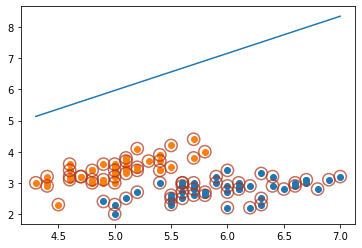

there are 75 Support Vectors.

the training error rate is: 0.000000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
the test error rate is: 0.000000


In [61]:
#通过训练数据计算 b, alphas
dataArr,labelArr = loadDataSet('trainingData.txt')
b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', 0.10))
drawDataMap(dataArr,labelArr,b,alphas)
getTrainingDataResult(dataArr, labelArr, b, alphas, 0.10)
dataArr1,labelArr1 = loadDataSet('testData.txt')
#测试结果
getTestDataResult(dataArr1, labelArr1, b, alphas, 0.10)

In [ ]:
[[-1.]]
[[-1.]]
[[-1.]]
[[-1.]]
[[1.]]
[[1.]]
[[1.]]
[[-1.]]
[[-1.]]
[[-1.]]
[[-1.]]

In [57]:
def loadDataSet(fileName):
    dataSet = []; labelSet = []
    fr = open(fileName)
    for line in fr.readlines():
        #分割
        lineArr =  line.strip().split()
        print(lineArr)
        dataSet.append([float(lineArr[0]), float(lineArr[1])])
        labelSet.append(float(lineArr[2]))
    return dataSet, labelSet
dataArr,labelArr = loadDataSet('testData.txt')


['3.542485', '1.977398', '-1']
['3.018896', '2.556416', '-1']
['7.551510', '-1.580030', '1']
['2.114999', '-0.004466', '-1']
['8.127113', '1.274372', '1']
['7.108772', '-0.986906', '1']
['8.610639', '2.046708', '1']
['2.326297', '0.265213', '-1']
['3.634009', '1.730537', '-1']
['0.341367', '-0.894998', '-1']
['3.125951', '0.293251', '-1']
['2.123252', '-0.783563', '-1']
['0.887835', '-2.797792', '-1']
['7.139979', '-2.329896', '1']
['1.696414', '-1.212496', '-1']
['8.117032', '0.623493', '1']
['8.497162', '-0.266649', '1']
['4.658191', '3.507396', '-1']
['8.197181', '1.545132', '1']
['1.208047', '0.213100', '-1']
['1.928486', '-0.321870', '-1']
['2.175808', '-0.014527', '-1']
['7.886608', '0.461755', '1']
['3.223038', '-0.552392', '-1']
['3.628502', '2.190585', '-1']
['7.407860', '-0.121961', '1']
['7.286357', '0.251077', '1']
['2.301095', '-0.533988', '-1']
['-0.232542', '-0.547690', '-1']
['3.457096', '-0.082216', '-1']
['3.023938', '-0.057392', '-1']
['8.015003', '0.885325', '1']
['